# Object Detection Model

This simply test the model by each frame or per image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install --upgrade tensorflow

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import os
import requests
from pathlib import Path

#Pose Detection (TFLite)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/movenet/tfLite/singlepose-thunder-tflite-float16")

print("Path to model files:", path)

Path to model files: /root/.cache/kagglehub/models/google/movenet/tfLite/singlepose-thunder-tflite-float16/1


In [ ]:
interpreter = tf.lite.Interpreter(model_path = "/root/.cache/kagglehub/models/google/movenet/tfLite/singlepose-thunder-tflite-float16/1/4.tflite")
interpreter.allocate_tensors()

In [ ]:
EDGE_LIST = [
    (0, 1),  # nose to left_eye
    (0, 2),  # nose to right_eye
    (1, 3),  # left_eye to left_ear
    (2, 4),  # right_eye to right_ear
    (0, 5),  # nose to left_shoulder
    (0, 6),  # nose to right_shoulder
    (5, 7),  # left_shoulder to left_elbow
    (7, 9),  # left_elbow to left_wrist
    (6, 8),  # right_shoulder to right_elbow
    (8, 10), # right_elbow to right_wrist
    (5, 6),  # left_shoulder to right_shoulder
    (5, 11), # left_shoulder to left_hip
    (6, 12), # right_shoulder to right_hip
    (11, 12),# left_hip to right_hip
    (11, 13),# left_hip to left_knee
    (13, 15),# left_knee to left_ankle
    (12, 14),# right_hip to right_knee
    (14, 16),# right_knee to right_ankle
]

# Function to draw keypoints and edges
def draw_keypoints_and_edges(frame, keypoints_with_scores, edges, confidence_threshold=0.4):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints_with_scores, [y, x, 1]))

    # Use white color for keypoints and edges to minimize the visual impact
    keypoint_color = (255, 255, 255)  # White
    edge_color = (255, 255, 255)  # White
    keypoint_thickness = 1
    edge_thickness = 1

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), keypoint_thickness, keypoint_color, -1)

    for edge in edges:
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if c1 > confidence_threshold and c2 > confidence_threshold:

            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), edge_color, edge_thickness)

    return frame

In [27]:
def video_num(video_path):
    video_files = []
    for root, dirs, files in os.walk(video_path):
        for file in files:
            if file.endswith('.mp4'):
                video_files.append(os.path.join(root, file))

    print(f"Found {len(video_files)} video files.")
    return video_files

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output_path = "/content/drive/MyDrive/Dataset/Pose_Val/Normal"

video_files = video_num("/content/drive/MyDrive/Dataset/Validation/Normal")

for video_file in video_files:
    print(f"Processing video: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue

    video_file_name = os.path.basename(video_file)
    output_video_file = os.path.join(output_path, f"pose_{video_file_name}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame for MoveNet
        input_frame = cv2.resize(frame, (256, 256))  # Resize to model's input size
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        input_frame = np.expand_dims(input_frame, axis=0)
        input_frame = input_frame.astype(np.uint8)

        interpreter.set_tensor(input_details[0]['index'], input_frame)
        interpreter.invoke()

        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

        frame = draw_keypoints_and_edges(frame, keypoints_with_scores[0], EDGE_LIST)

        out.write(frame)

    cap.release()
    out.release()
    print(f"Video processing completed for: {video_file}")

Found 21 video files.
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (71).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (71).mp4
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (70).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (70).mp4
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (72).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (72).mp4
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (73).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (73).mp4
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (74).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (74).mp4
Processing video: /content/drive/MyDrive/Dataset/Validation/Normal/Normal (75)

#Mask R-CNN

In [9]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!rm -rf /content/mask_rcnn.egg-info

In [ ]:
#!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
#!pip3 install -r /content/drive/MyDrive/Mask-RCNN-TF2-3.0/requirements.txt

In [10]:
!git clone https://github.com/BupyeongHealer/Mask_RCNN_tf_2.x.git

Cloning into 'Mask_RCNN_tf_2.x'...
remote: Enumerating objects: 964, done.
remote: Total 964 (delta 0), reused 0 (delta 0), pack-reused 964
Receiving objects: 100% (964/964), 126.42 MiB | 25.53 MiB/s, done.
Resolving deltas: 100% (573/573), done.
Updating files: 100% (76/76), done.


In [13]:
%cd /content/drive/MyDrive/Mask_RCNN_tf_2.x/

/content/drive/MyDrive/Mask_RCNN_tf_2.x


In [15]:
import mrcnn.model

/usr/local/lib/python3.10/dist-packages/mrcnn/model.py:2337: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [5]:
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
#Now import hyper
import hyper

In [ ]:
from tensorflow.keras.metrics import Metric

In [6]:
from mrcnn import utils
import mrcnn.model as modellib

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [33]:

#import mrcnn.config
#import mrcnn.model
#import mrcnn.visualize
import cv2
import os

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"

    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
# Download the mask_rcnn_coco.h5 file from this link: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
model.load_weights(filepath="mask_rcnn_coco.h5",
                   by_name=True)

AttributeError: module 'mrcnn' has no attribute 'model'

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#YOLO Model Object Detection

In [ ]:
#url = "https:///Users/chankit/prototype/my_video_frame.png"
#image = Image.open(requests.get(url, stream=True).raw)

image = Image.open("/Users/chankit/prototype/my_video_frame.png")

oomodel = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images= image, return_tensors="pt")
outputs = oomodel(**inputs)

logits = outputs.logits
bboxes = outputs.pred_boxes

target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {oomodel.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 1.0 at location [218.88, 187.2, 374.54, 470.32]
Detected keyboard with confidence 0.933 at location [380.09, 444.05, 537.29, 479.89]
Detected chair with confidence 0.986 at location [131.31, 222.21, 212.83, 347.28]
Detected chair with confidence 0.92 at location [0.29, 233.9, 95.87, 372.42]


This part is the actual execution of drawing bounding boxes for each video

In [ ]:

video_file = '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (5).mp4'

print(f"Processing video: {video_file}")
cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print(f"Could not open video: {video_file}")

video_file_name = os.path.basename(video_file)
output_path='/content/drive/MyDrive/Dataset/video.mp4'
output_video_file = os.path.join(output_path, f"processed_{video_file_name}")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculate the frame step to achieve approximately 120 frames in the output
# Ensuring the step is at least 1
frame_step = max(1, total_frames // 120)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

processed_frame_count = 0

for frame_count in range(0, total_frames, frame_step):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

    ret, frame = cap.read()
    if not ret:
        print("Can't fetch the frame.")
        break

    resized_frame = cv2.resize(frame, (180, 180))
    out.write(resized_frame)
    processed_frame_count += 1

    if processed_frame_count >= 120:
        break

cap.release()
out.release()
print(f"Video processing completed for: {video_file}")


Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (5).mp4
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (5).mp4


In [ ]:
!pip install tensorflow numpy opencv-python-headless h5py

In [ ]:
import h5py
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

# Initialize InceptionV3 for feature extraction
base_model = InceptionV3(weights='imagenet', include_top=False)

names = ['mixed6', 'mixed8']
layers = [base_model.get_layer(name).output for name in names]
model = tf.keras.Model(inputs=base_model.input, outputs=layers)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
def save_features_as_npy(features, npy_path):
    np.save(npy_path, features)

def extract_and_process_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (299, 299))
        frame = frame[..., ::-1]
        frame = preprocess_input(frame)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def process_videos(video_paths, output_directory):
    for video_path in video_paths:
        video_id = os.path.basename(video_path).split('.')[0]  # Use filename as ID
        print(f"Processing {video_id}...")

        frames = extract_and_process_frames(video_path)
        features = model.predict(frames)

        # Define the path for saving the .npy file for each video
        npy_path = os.path.join(output_directory, f"{video_id}_features.npy")

        # Iterate over each feature array and save individually
        for i, feature in enumerate(features):
            individual_npy_path = os.path.join(output_directory, f"{video_id}_feature_{i}.npy")
            np.save(individual_npy_path, feature)

    print("All videos processed.")

# Example usage
directory_path = '/content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting'
numpy_path = '/content/drive/MyDrive/Dataset/features'

video_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.mp4')]
process_videos(video_paths, numpy_path)

In [ ]:
# Use for Later

def load_video_features(video_id, features_directory):
    npy_path = os.path.join(features_directory, f"{video_id}_features.npy")
    return np.load(npy_path)

# Example loading
video_id = 'example_video_id'
features_directory = 'path/to/save/features'
features = load_video_features(video_id, features_directory)

# Data Augmentation

**Flipped Video**

In [32]:
output_path = "/content/drive/MyDrive/Dataset/Pose_Val/Normal"

video_files = video_num("/content/drive/MyDrive/Dataset/Pose_Val/Normal")

for video_file in video_files:
    print(f"Processing video: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue

    video_file_name = os.path.basename(video_file)
    output_video_file = os.path.join(output_path, f"flipped_{video_file_name}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video, or can't fetch the frame.")
            break

        # Flip the frame horizontally (like a mirror)
        flipped_frame = cv2.flip(frame, 1)

        out.write(flipped_frame)

    cap.release()
    out.release()

    print(f"Video processing completed for: {video_file}")

Found 21 video files.
Processing video: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (71).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (71).mp4
Processing video: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (70).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (70).mp4
Processing video: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (72).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (72).mp4
Processing video: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (73).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/Pose_Val/Normal/pose_Normal (73).mp4
Processing video: /content/drive/MyDrive/D

In [ ]:
# Changing color of video
output_path = "/content/drive/MyDrive/Dataset/SSD_Train/Color"
video_files = video_num("/content/drive/MyDrive/Dataset/SSD_Train/Normal")

for video_file in video_files:
    print(f"Processing video: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue

    video_file_name = os.path.basename(video_file)
    output_video_file = os.path.join(output_path, f"contrast_{video_file_name}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

    # Generate a random contrast adjustment factor for this video
    alpha = np.random.uniform(0.5, 1.5)
    beta = np.random.uniform(0, 1)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video, or can't fetch the frame.")
            break

        # Adjust contrast for the frame
        adjusted_frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

        out.write(adjusted_frame)

    cap.release()
    out.release()

    print(f"Video processing completed for: {video_file}")

Found 208 video files.
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (42).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (42).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (43).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (43).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (26).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (26).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (44).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (4

In [ ]:
# SSD Model
import cv2
import os
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf
import tensorflow_hub as hub

def make_processed_videos(output_path, video_files):
    detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

    for video_file in video_files:
        print(f"Processing video: {video_file}")
        cap = cv2.VideoCapture(video_file)

        if not cap.isOpened():
            print(f"Could not open video: {video_file}")
            continue

        video_file_name = os.path.basename(video_file)
        output_video_file = os.path.join(output_path, f"processed_{video_file_name}")

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Reached end of video, or can't fetch the frame.")
                break

            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            image_np = np.array(image)
            input_tensor = tf.convert_to_tensor([image_np], dtype=tf.uint8)

            # Perform detection
            detector_output = detector(input_tensor)
            class_ids = detector_output["detection_classes"]
            boxes = detector_output["detection_boxes"]
            scores = detector_output["detection_scores"]

            # Draw bounding boxes and labels on the image
            draw = ImageDraw.Draw(image)
            for i in range(boxes.shape[1]):
                if scores[0, i] > 0.7:
                    box = boxes[0, i].numpy()
                    ymin, xmin, ymax, xmax = box
                    (left, right, top, bottom) = (xmin * frame_width, xmax * frame_width,
                                                  ymin * frame_height, ymax * frame_height)

                    draw.rectangle([left, top, right, bottom], outline="red", width=2)
                    #class_id = class_ids[0, i].numpy()
                    #score = scores[0, i].numpy()
                    #label_text = f"Class {int(class_id)}: {round(score, 3)}"
                    #draw.text((left, top - 10), fill="red")

            frame_with_detections = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            out.write(frame_with_detections)

        cap.release()
        out.release()

In [ ]:
video_num("/content/drive/MyDrive/Dataset/SSD_Train/Normal")

Found 156 video files.


['/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (34).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (35).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (36).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (37).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (38).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (39).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (40).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (41).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (42).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (43).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (26).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Normal (44).mp4',
 '/content/drive/MyDrive/Dataset/SSD_Train/Normal/processed_Norm

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_Train/Normal"
video_files = video_num("/content/drive/MyDrive/Dataset/Train/Normal/placeholder")
make_processed_videos(output_path, video_files)

Found 25 video files.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (1).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (10).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (11).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (12).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (13).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (14).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Normal/placeholder/Normal (15).mp4
Reached end of video, or can't fetch the frame.
Processing vi

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_TS"
video_files = video_num("/content/drive/MyDrive/Dataset/Train/Shoplifting")
make_processed_videos(output_path, video_files)

Found 68 video files.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (1).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (10).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (11).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (12).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (13).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (14).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Train/Shoplifting/Shoplifting (15).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_VN"
video_files = video_num("/content/drive/MyDrive/Dataset/Validation/Normal")
make_processed_videos(output_path, video_files)

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_VS"
video_files = video_num("/content/drive/MyDrive/Dataset/Validation/Shoplifting")
make_processed_videos(output_path, video_files)

Found 24 video files.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (70).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (71).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (72).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (73).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (74).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (75).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (76).mp4
Reached end of video, or can't fetch th

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/ProcessedValidation"

def make_processed_videos(output_path, video_files):

  for video_file in video_files:
      print(f"Processing video: {video_file}")
      cap = cv2.VideoCapture(video_file)

      if not cap.isOpened():
          print(f"Could not open video: {video_file}")
          continue

      video_file_name = os.path.basename(video_file)
      output_video_file = os.path.join(output_path, f"processed_{video_file_name}")

      frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      fps = cap.get(cv2.CAP_PROP_FPS)

      fourcc = cv2.VideoWriter_fourcc(*'mp4v')
      out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

      while True:
          ret, frame = cap.read()
          if not ret:
              print("Reached end of video, or can't fetch the frame.")
              break

          image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

          inputs = image_processor(images=image, return_tensors="pt")
          outputs = oomodel(**inputs)

          target_sizes = torch.tensor([image.size[::-1]])
          results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

          draw = ImageDraw.Draw(image)
          for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
              box = [round(i, 2) for i in box.tolist()]
              draw.rectangle(box, outline="red", width=2)
              label_text = f"{oomodel.config.id2label[label.item()]}: {round(score.item(), 3)}"
              draw.text((box[0], box[1] - 10), label_text, fill="red")

          frame_with_detections = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)


          out.write(frame_with_detections)

      cap.release()
      out.release()


In [ ]:
def make_processed_videos(output_path, video_file):

      cap = cv2.VideoCapture(video_file)

      if not cap.isOpened():
          print(f"Could not open video: {video_file}")

      video_file_name = os.path.basename(video_file)
      output_video_file = os.path.join(output_path, f"processed_{video_file_name}")

      frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      fps = cap.get(cv2.CAP_PROP_FPS)


      fourcc = cv2.VideoWriter_fourcc(*'mp4v')
      out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

      while True:
          ret, frame = cap.read()
          if not ret:
              print("Reached end of video, or can't fetch the frame.")
              break


          image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

          inputs = image_processor(images=image, return_tensors="pt")
          outputs = oomodel(**inputs)

          target_sizes = torch.tensor([image.size[::-1]])
          results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

          draw = ImageDraw.Draw(image)
          for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
              box = [round(i, 2) for i in box.tolist()]
              draw.rectangle(box, outline="red", width=2)
              label_text = f"{oomodel.config.id2label[label.item()]}: {round(score.item(), 3)}"
              draw.text((box[0], box[1] - 10), label_text, fill="red")

          frame_with_detections = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

          out.write(frame_with_detections)

      cap.release()
      out.release()

make_processed_videos("/content/drive/MyDrive/Dataset/ProcessedValidation/Normal", "/content/drive/MyDrive/Dataset/Validation/Normal/Normal (71).mp4")

Reached end of video, or can't fetch the frame.


In [ ]:
v_file = video_num("/content/drive/MyDrive/Dataset/Validation/Shoplifting")
output_p = "/content/drive/MyDrive/Dataset/ProcessedValidation"

Found 24 video files.


In [ ]:
make_processed_videos(output_p, v_file)

Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (70).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (71).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (72).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (73).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (74).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (75).mp4
Reached end of video, or can't fetch the frame.
Processing video: /content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (76).mp4
Reached end of video, or can't fetch the frame.
Processing vi

In [ ]:
# View the length of trained processed data using the function

video_num("/Users/chankit/prototype/Dataset/ProcessedDataset")

Found 137 video files.


# Data Augmentation

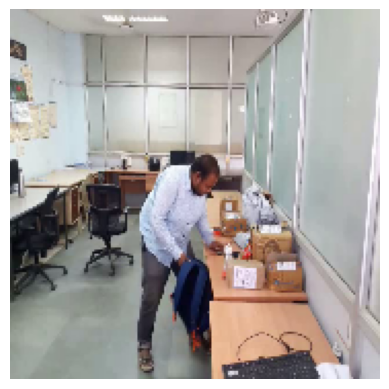

In [ ]:
IMG_SIZE = 180


resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


image_path = 'my_video_frame.png'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw, channels=3)
image = tf.expand_dims(image, 0)  # Add batch dimension

processed_image = resize_and_rescale(image)

processed_image_np = tf.squeeze(processed_image).numpy()

plt.imshow(processed_image_np)
plt.axis('off')
plt.show()

**Resize and Rescale Original Videos**

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_Train/Augmented"

video_files = video_num("/content/drive/MyDrive/Dataset/SSD_Train/Shoplifting")

for video_file in video_files:
    print(f"Processing video: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue

    video_file_name = os.path.basename(video_file)
    output_video_file = os.path.join(output_path, f"processed_{video_file_name}")


    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video, or can't fetch the frame.")
            break

        center = (frame_width // 2, frame_height // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, 30, 1)

        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame_width, frame_height))

        out.write(rotated_frame)

    cap.release()
    out.release()

    print(f"Video processing completed for: {video_file}")

Found 68 video files.
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (1).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (1).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (10).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (10).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (11).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (11).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (12).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: 

**Gaussian Patch**

In [ ]:
def add_gaussian_noise_patch_to_frame(frame, patch_size=(32, 32), mean=0.0, stddev=50.0):
    noise_patch = np.random.normal(mean, stddev, (*patch_size, frame.shape[-1])).astype('uint8')

    # Choose a random location in the frame
    max_y = frame.shape[0] - patch_size[0]
    max_x = frame.shape[1] - patch_size[1]
    start_y = np.random.randint(0, max_y) if max_y > 0 else 0
    start_x = np.random.randint(0, max_x) if max_x > 0 else 0

    # Add the noise patch to the frame
    frame_with_noise = np.copy(frame)
    frame_with_noise[start_y:start_y+patch_size[0], start_x:start_x+patch_size[1], :] += noise_patch

    # Ensure frame values are within valid range
    frame_with_noise = np.clip(frame_with_noise, 0, 255)
    return frame_with_noise

In [ ]:
output_path = "/content/drive/MyDrive/Dataset/SSD_Train/Shoplifting"

video_files = video_num("/content/drive/MyDrive/Dataset/SSD_Train/Shoplifting")

for video_file in video_files:
    print(f"Processing video: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue

    video_file_name = os.path.basename(video_file)
    output_video_file = os.path.join(output_path, f"gaussian_{video_file_name}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_file, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video, or can't fetch the frame.")
            break

        gaussian_frame = add_gaussian_noise_patch_to_frame(frame)

        out.write(gaussian_frame)

    cap.release()
    out.release()

    print(f"Video processing completed for: {video_file}")

Found 245 video files.
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (1).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (1).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (10).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (10).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (11).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (11).mp4
Processing video: /content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (12).mp4
Reached end of video, or can't fetch the frame.
Video processing completed for:

In [ ]:
prefix = 'augmented_'

def name_converter(directory):
  for filename in os.listdir(directory):
      if filename.endswith('.mp4'):
          new_name = prefix + filename
          old_path = os.path.join(directory, filename)
          new_path = os.path.join(directory, new_name)
          os.rename(old_path, new_path)
          print(f'Renamed {filename} to {new_name}')

In [ ]:
name_converter('/content/drive/MyDrive/Dataset/AugmentedTrain/Normal')

In [ ]:
name_converter('/content/drive/MyDrive/Dataset/AugmentedTrain/Shoplifting')
name_converter('/content/drive/MyDrive/Dataset/AugmentedValidation/Normal')
name_converter('/content/drive/MyDrive/Dataset/AugmentedValidation/Shoplifting')

In [ ]:
current_folder_name = '/content/drive/MyDrive/Dataset/ProcessedDataset/Normal (1)'
new_folder_name = '/content/drive/MyDrive/Dataset/ProcessedDataset/Normal'

# Rename the folder
def folder_name_convert(current_folder_name, new_folder_name):
    os.rename(current_folder_name, new_folder_name)

    print(f"Folder renamed from {current_folder_name} to {new_folder_name}")

In [ ]:
video_num('/content/drive/MyDrive/Dataset/ProcessedValidation')

In [ ]:
folder_name_convert('/content/drive/MyDrive/Dataset/ProcessedValidation/Shoplifting (1)', '/content/drive/MyDrive/Dataset/ProcessedValidation/Shoplifting')

Folder renamed from /content/drive/MyDrive/Dataset/ProcessedValidation/Shoplifting (1) to /content/drive/MyDrive/Dataset/ProcessedValidation/Shoplifting


In [ ]:
folder_name_convert('/content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting (1)', '/content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting')

Folder renamed from /content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting (1) to /content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting


In [ ]:
video_num('/content/drive/MyDrive/Dataset/ProcessedDataset/Shoplifting')

In [ ]:
video_num('/content/drive/MyDrive/Dataset/ProcessedDataset/Normal')